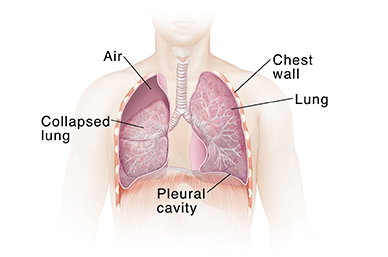

<h1 style="text-align:center;font-size:30px;" > SIIM-ACR Pneumothorax Segmentation </h1>

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p> A pneumothorax or collapsed lungs is a medical condition that is responsible for making the people suddenly gasp for air, and feel helplessly breathless for no apparent reason. It can be a complete lung collapse or a collapse of a portion of the lung. It is usually diagnosed by a radiologist with several years of experience on a chest x- ray; which sometimes is very difficult to confirm. 
Our goal is to classify(if present segment) pneumothorax from a set of chest radiographic images.


This is a Kaggle problem. (https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview)
</p>

<h2> 1.2 Problem Statement </h2>

<p> Classify pneumothorax from a set of chest radiographic images and if present segment the regions of pneumnothorax. </p>

<h2> 1.3 Sources </h2>



*   Source : https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview
*   



<h2>1.4 Real world/Business Objectives and Constraints </h2>



*   Classify pneumothorax and if present segment it.
*   Maximize the overlap between the actual mask and predicted mask(Dice).
*   No such latency concerns.



<h1>2. Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data is present in under folder SIIM. It contains three folders and files, <br>

*   dicom-images-test
*   dicom-images-train
*   train-rle.csv

Note : I downloaded the data from https://www.kaggle.com/seesee/siim-train-test as the data is removed from the Cloud Healthcare API.
</p>

<h2>2.2 Mapping the real world problem to a Deep Learning Problem </h2>

<h3> 2.2.1 Type of Deep Learning Problem </h3>

<p>It is a basically a semantic image segmentation problem, where we have to segment areas of pneumothorax. </p>

<h3> 2.2.2 Performance Metric </h3>

Source:  https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data

Metric: 
* Focal Loss + Dice Loss

  - Focal loss is very good for imbalanced data as it focuses more on hard examples than easy examples. Our data is very imbalanced as the area having pneumothorax is very small. Dice is best metric overall. So we are going for the combination of the two.

<h3> 2.2.3 Necessary Imports </h3>

In [ ]:
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 6.2MB/s 


In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
from tqdm import tqdm
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")
import gc
gc.collect()
import cv2
import tensorflow as tf
import keras
from PIL import Image, ImageDraw
from PIL import ImagePath
import imgaug.augmenters as iaa
from skimage import exposure

<h1>1. Creating train and test dataset </h1>

In [ ]:
data_rle_train = pd.read_csv("./siim/train-rle.csv")
data_rle_train.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [ ]:
#The second column contains a space infront of it so manually rewriting it
data_rle_train.columns = ['ImageId', 'EncodedPixels']

In [ ]:
#https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
def getInfoDICOM(path, toPrint = False, train = True):

    info = {}

    path = os.path.join(path)
    #reading the data using methods of pydicom
    data = pydicom.dcmread(path)
    info['path'] = path
    info['age'] = data.PatientAge
    info['sex']= data.PatientSex
    info['ImageId'] = data.SOPInstanceUID
    
    if train: #test doesn't have encoded pixels data, we have to predict them
        #SOPInstanceUID contains the storage type which resembles the image ids given in train-rle dataset
        encodedPixels = data_rle_train[data_rle_train['ImageId'] == data.SOPInstanceUID]["EncodedPixels"].values
        info['encodedPixels'] = encodedPixels

        info['lenOfEncodedPixels'] = len(encodedPixels)

        #this is for visualization purpose
        if '-1' in encodedPixels or len(encodedPixels) == 0:
            info['has_pneumothorax'] = 0 
        else:
            info['has_pneumothorax'] = 1
    
    if toPrint:
        print("Path...............:", path)
        print("Patient's Name.....:", data.PatientName)
        print("Patient's Id.......:", data.PatientID)
        print("Patient's Age......:", data.PatientAge)
        print("Patient's Sex......:", data.PatientSex)

        print("Original X Ray")
        plt.figure(figsize=(10,10))
        plt.imshow(data.pixel_array, cmap=plt.cm.bone)
        plt.show()


    return info

In [ ]:
#creation of train dataset
#https://stackoverflow.com/questions/33747968/getting-file-list-using-glob-in-python
filesList = glob.glob('./siim/dicom-images-train/*/*/*.dcm')
train = pd.DataFrame()
train_list = []
for file in tqdm(filesList):
    info = getInfoDICOM(file, False, True)
    train_list.append(info)
train = pd.DataFrame(train_list)

100%|██████████| 12089/12089 [00:40<00:00, 296.59it/s]


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12089 entries, 0 to 12088
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path                12089 non-null  object
 1   age                 12089 non-null  object
 2   sex                 12089 non-null  object
 3   ImageId             12089 non-null  object
 4   encodedPixels       12089 non-null  object
 5   lenOfEncodedPixels  12089 non-null  int64 
 6   has_pneumothorax    12089 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 661.2+ KB


In [ ]:
train.head(5)

,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax
0,./siim/dicom-images-train/1.2.276.0.7230010.3....,73,M,1.2.276.0.7230010.3.1.4.8323329.6277.151787519...,[-1],1,0
1,./siim/dicom-images-train/1.2.276.0.7230010.3....,10,F,1.2.276.0.7230010.3.1.4.8323329.7035.151787520...,[-1],1,0
2,./siim/dicom-images-train/1.2.276.0.7230010.3....,64,M,1.2.276.0.7230010.3.1.4.8323329.14139.15178752...,[97859 17 1005 20 995 29 992 33 988 36 981 43 ...,1,1
3,./siim/dicom-images-train/1.2.276.0.7230010.3....,22,F,1.2.276.0.7230010.3.1.4.8323329.3216.151787517...,[-1],1,0
4,./siim/dicom-images-train/1.2.276.0.7230010.3....,48,M,1.2.276.0.7230010.3.1.4.8323329.2185.151787517...,[256251 3 1019 4 1019 5 1017 6 1016 8 1014 9 1...,3,1


In [ ]:
#creation of test dataset
filesList = glob.glob('./siim/dicom-images-test/*/*/*.dcm')
test = pd.DataFrame()
test_list = []
for file in tqdm(filesList):
    info = getInfoDICOM(file, False, False)
    test_list.append(info)
test = pd.DataFrame(test_list)

100%|██████████| 3205/3205 [00:12<00:00, 262.88it/s]


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3205 entries, 0 to 3204
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   path     3205 non-null   object
 1   age      3205 non-null   object
 2   sex      3205 non-null   object
 3   ImageId  3205 non-null   object
dtypes: object(4)
memory usage: 100.3+ KB


In [ ]:
test.head(5)

,path,age,sex,ImageId
0,./siim/dicom-images-test/_/_/ID_af8eb43f4.dcm,22,M,ID_af8eb43f4
1,./siim/dicom-images-test/_/_/ID_114609bb6.dcm,19,M,ID_114609bb6
2,./siim/dicom-images-test/_/_/ID_2e2105281.dcm,41,M,ID_2e2105281
3,./siim/dicom-images-test/_/_/ID_e7eac7dab.dcm,41,M,ID_e7eac7dab
4,./siim/dicom-images-test/_/_/ID_7aef3400f.dcm,83,F,ID_7aef3400f


In [ ]:
print("Columns having null values in train", train.columns[train.isnull().any()].tolist())

Columns having null values in train []


In [ ]:
print("No of images having no mask", train[train['lenOfEncodedPixels'] == 0].shape[0])

No of images having no mask 42


In [ ]:
train.loc[train.lenOfEncodedPixels == 0 , 'encodedPixels'] = np.array(-1)

<h1> 2. Data Preparation </h1>

In [ ]:
def computeMasks(train, path):
    mask_paths = []
    for index, row in tqdm(train.iterrows()):
        pixels = row['encodedPixels']
        mask = np.zeros((1024, 1024))
        if row['has_pneumothorax'] == 1:          
            for pix in pixels:
                mask = mask + rle2mask(pix, 1024, 1024).T       
        img = Image.fromarray(mask).convert('L')
        path2save = path + str(index+1) + ".jpg"
        img.save(path2save)
        mask_paths.append(path2save)
    train["mask"] = mask_paths
    return train

In [ ]:
path = "siim/dicom-mask-train/"
try:
    os.makedirs(path)
except:
    pass
train = computeMasks(train, path)
train.head(2)

12089it [06:14, 32.28it/s]


,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax,mask
0,./siim/dicom-images-train/1.2.276.0.7230010.3....,57,F,1.2.276.0.7230010.3.1.4.8323329.13904.15178752...,[-1],1,0,siim/dicom-mask-train/1.jpg
1,./siim/dicom-images-train/1.2.276.0.7230010.3....,52,F,1.2.276.0.7230010.3.1.4.8323329.5535.151787518...,[-1],1,0,siim/dicom-mask-train/2.jpg


In [ ]:
def convertImagesToJpeg(train, path):
    images_paths = []
    for index, row in tqdm(train.iterrows()):
        path2dicom = row['path']
        ds = pydicom.read_file(path2dicom) # read dicom image
        img = ds.pixel_array # get image array
        img_mem = Image.fromarray(img) # Creates an image memory from an object exporting the array interface
        path2save = path + str(index + 1)  + ".jpg"
        img_mem.save(path2save)
        images_paths.append(path2save)
    train["images_paths"] = images_paths
    return train

In [ ]:
path = "siim/dicom-images-train-jpg/"
try:
    os.makedirs(path)
except:
    pass
train = convertImagesToJpeg(train, path)
train.head(2)

12089it [06:00, 33.51it/s]


,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax,mask,images_paths
0,./siim/dicom-images-train/1.2.276.0.7230010.3....,57,F,1.2.276.0.7230010.3.1.4.8323329.13904.15178752...,[-1],1,0,siim/dicom-mask-train/1.jpg,siim/dicom-images-train-jpg/1.jpg
1,./siim/dicom-images-train/1.2.276.0.7230010.3....,52,F,1.2.276.0.7230010.3.1.4.8323329.5535.151787518...,[-1],1,0,siim/dicom-mask-train/2.jpg,siim/dicom-images-train-jpg/2.jpg


In [ ]:
path = "siim/dicom-images-test-jpg/"
try:
    os.makedirs(path)
except:
    pass
test = convertImagesToJpeg(test, path)
test.head(2)

3205it [01:32, 34.79it/s]


,path,age,sex,ImageId,images_paths
0,./siim/dicom-images-test/_/_/ID_bf9328240.dcm,38,F,ID_bf9328240,siim/dicom-images-test-jpg/1.jpg
1,./siim/dicom-images-test/_/_/ID_a49ab23fd.dcm,53,M,ID_a49ab23fd,siim/dicom-images-test-jpg/2.jpg


<h1>3. Data Pipeline</h1>

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform, he_normal
from tensorflow.keras.losses import binary_crossentropy
K.set_image_data_format('channels_last')

In [ ]:
fileNames = train['images_paths']
labels = train['has_pneumothorax']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fileNames, labels, test_size=0.10, stratify = labels, random_state=42)

In [ ]:
X_train.head(2)

8489    siim/dicom-images-train-jpg/8490.jpg
9227    siim/dicom-images-train-jpg/9228.jpg
Name: images_paths, dtype: object

In [ ]:
y_train.head(2)

8489    1
9227    0
Name: has_pneumothorax, dtype: int64

In [ ]:
img_size = 256

In [ ]:
def read_image(datapoint):
    image = tf.keras.preprocessing.image.load_img(datapoint)
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction
    return image

def read_label(datapoint):
    datapoint = tf.reshape(datapoint, [1])
    return datapoint

def preprocess(image, label):
    def f(image, label):

        image = image.decode()
        image = read_image(image)

        a = np.random.uniform()
        if a>=0.80:
            b = np.random.uniform()
            if b<0.50:
                image = tf.image.flip_left_right(image)
            else:
                image = tf.image.flip_up_down(image)

        label = read_label(label)
        return image, label
    images, labels = tf.numpy_function(f, [image, label], [tf.float32, tf.int64])
    images.set_shape([img_size, img_size, 3])
    labels.set_shape([1])
    return images, labels

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=15000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
train_data = tf_dataset(X_train.values, y_train.values)

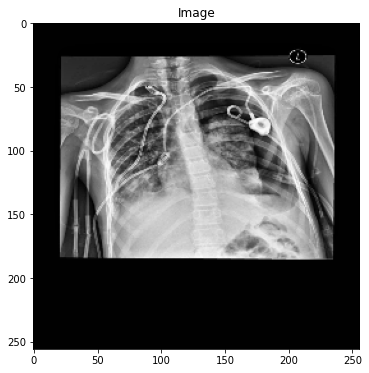

tf.Tensor([1], shape=(1,), dtype=int64)


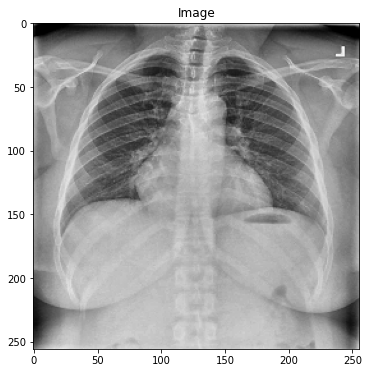

tf.Tensor([0], shape=(1,), dtype=int64)


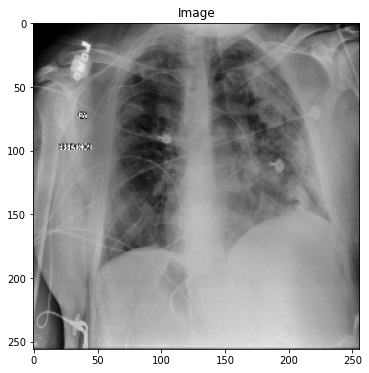

tf.Tensor([0], shape=(1,), dtype=int64)


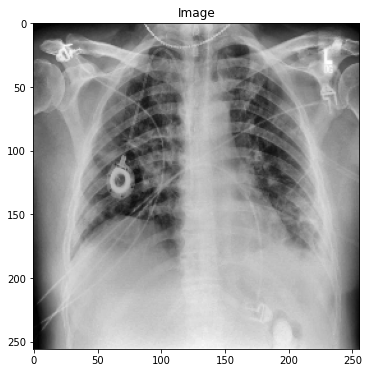

tf.Tensor([0], shape=(1,), dtype=int64)


In [ ]:
for image, result in train_data.take(1):
    sample_image, sample_result = image, result
for i in range(4):
    plt.figure(figsize=(6, 6))
    plt.title("Image")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(sample_image[i]))
    plt.show()
    plt.close()
    print(sample_result[i])

In [ ]:
def read_image(datapoint):
    image = tf.keras.preprocessing.image.load_img(datapoint)
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction
    return image

def read_label(datapoint):
    datapoint = tf.reshape(datapoint, [1])
    return datapoint

def preprocess(image, label):
    def f(image, label):

        image = image.decode()
        image = read_image(image)

        label = read_label(label)
        return image, label
    images, labels = tf.numpy_function(f, [image, label], [tf.float32, tf.int64])
    images.set_shape([img_size, img_size, 3])
    labels.set_shape([1])
    return images, labels

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=15000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
test_data = tf_dataset(X_test.values, y_test.values)

<h1>6. Model </h1>

In [ ]:
from sklearn import metrics

In [ ]:
class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filters, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1_basic = Conv2D(filters=filters, kernel_size=(3, 3),strides=stride, padding="same", activation = "relu")
        self.batchNorm1_basic = BatchNormalization()
        self.conv2_basic = Conv2D(filters=filters,kernel_size=(3, 3),strides=1,padding="same", activation = "relu")
        self.batchNorm2_basic = BatchNormalization()
        if stride != 1:
            self.downsample_basic = tf.keras.Sequential()
            self.downsample_basic.add(Conv2D(filters=filters, kernel_size=(1, 1), strides=stride,  activation = "relu"))
            self.downsample_basic.add(BatchNormalization())
        else:
            self.downsample_basic = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample_basic(inputs)

        x = self.conv1_basic(inputs)
        x = self.batchNorm1_basic(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2_basic(x)
        x = self.batchNorm2_basic(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


In [ ]:
class Resnet34(tf.keras.Model):
    def __init__(self, input_shape, layer_params):
        super().__init__()

        self.conv1_resnet = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1_resnet = tf.keras.layers.BatchNormalization()
        self.pool1_resnet = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1_resnet = make_basic_block_layer(filter_num=32,
                                             blocks=layer_params[0])
        self.layer2_resnet = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3_resnet = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4_resnet = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool_resnet = tf.keras.layers.AveragePooling2D()
        self.flatten = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(300, activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(50, activation = 'relu')
        self.final = tf.keras.layers.Dense(1, activation= 'sigmoid')
        

    def call(self, inputs, training=None, mask=None):
        x = self.conv1_resnet(inputs)
        x = self.bn1_resnet(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1_resnet(x)
        x = self.layer1_resnet(x, training=training)
        x = self.layer2_resnet(x, training=training)
        x = self.layer3_resnet(x, training=training)
        x = self.layer4_resnet(x, training=training)
        x = self.avgpool_resnet(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        output = self.final(x)
        return output

In [ ]:
model3 = Resnet34((256, 256, 3),[3, 4, 6, 3])

In [ ]:
class History_Callback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        
        val_predict = []
        for i in range(len(X_test)):
            image = tf.keras.preprocessing.image.load_img(X_test.iloc[i])
            image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
            image = tf.image.resize(image, [img_size, img_size])
            image = image / 255.0
            image = exposure.equalize_adapthist(image)
            image = tf.expand_dims(image, axis = 0)
            predict = self.model.predict(image)
            val_predict.append(np.squeeze(predict, axis = -1).round())

        val_targ = y_test
        f1_score = metrics.f1_score(val_targ, val_predict)       
        auc = metrics.roc_auc_score(val_targ, val_predict)
        recall = metrics.recall_score(val_targ, val_predict)

        print("recall:  {recall} - f1Score: {f1score} - AUC: {AUC}".format(f1score = f1_score, AUC = auc, recall = recall))
        

history_Model1 = History_Callback()

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model3.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min'),
             history_Model1
]
optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
model3.compile(optimizer, loss = 'binary_crossentropy' , metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_data, steps_per_epoch=len(train_data), epochs=25,\
                              validation_data=test_data,callbacks=callbacks, )

Epoch 1/25
1360/1360 [==============================] - 636s 464ms/step - loss: 0.7192 - accuracy: 0.7536 - val_loss: 1.0108 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 2/25
1360/1360 [==============================] - 622s 457ms/step - loss: 0.5321 - accuracy: 0.7803 - val_loss: 0.5267 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 3/25
1360/1360 [==============================] - 628s 462ms/step - loss: 0.5216 - accuracy: 0.7813 - val_loss: 0.5792 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 4/25
1360/1360 [==============================] - 623s 458ms/step - loss: 0.5238 - accuracy: 0.7802 - val_loss: 0.5215 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 5/25
1360/1360 [==============================] - 614s 452ms/step - loss: 0.5141 - accuracy: 0.7796 - val_loss: 0.5412 - val_accuracy: 0.7767
recall:  0.02247191011235955 - f1Score: 0.0410958904109589 - AUC: 0.5011510293661586
Epoch 6/25
1360/136

In [ ]:
#this is after changed pipeline
history3 = model3.fit(train_data, steps_per_epoch=len(train_data), epochs=1,\
                              validation_data=test_data,callbacks=callbacks, )

   2/1360 [..............................] - ETA: 55:39 - loss: 0.6746 - accuracy: 0.8750  

KeyboardInterrupt: ignored

In [ ]:
history3 = model3.fit(train_data, steps_per_epoch=len(train_data), epochs=25,\
                              validation_data=test_data,callbacks=callbacks, )

Epoch 1/25
1360/1360 [==============================] - 642s 472ms/step - loss: 0.5306 - accuracy: 0.7788 - val_loss: 0.6501 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 2/25
1360/1360 [==============================] - 641s 471ms/step - loss: 0.5296 - accuracy: 0.7790 - val_loss: 0.5285 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 3/25
1360/1360 [==============================] - 635s 467ms/step - loss: 0.5216 - accuracy: 0.7791 - val_loss: 0.5505 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 4/25
1360/1360 [==============================] - 632s 465ms/step - loss: 0.5276 - accuracy: 0.7790 - val_loss: 0.5501 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 5/25
1360/1360 [==============================] - 636s 467ms/step - loss: 0.5177 - accuracy: 0.7791 - val_loss: 0.5430 - val_accuracy: 0.7792
recall:  0.0 - f1Score: 0.0 - AUC: 0.5
Epoch 6/25
1360/1360 [==============================] - 635s 467m

In [ ]:
history3 = model3.fit(train_data, steps_per_epoch=len(train_data), epochs=20,\
                              validation_data=test_data,callbacks=callbacks, )

Epoch 1/20
1360/1360 [==============================] - 681s 500ms/step - loss: 0.4165 - accuracy: 0.8073 - val_loss: 0.4383 - val_accuracy: 0.8056
recall:  0.38202247191011235 - f1Score: 0.4646924829157176 - AUC: 0.6538562465707675
Epoch 2/20
1360/1360 [==============================] - 686s 504ms/step - loss: 0.4053 - accuracy: 0.8119 - val_loss: 0.4066 - val_accuracy: 0.7990
recall:  0.2958801498127341 - f1Score: 0.3940149625935162 - AUC: 0.6187468689615688
Epoch 3/20
1360/1360 [==============================] - 700s 515ms/step - loss: 0.4017 - accuracy: 0.8176 - val_loss: 0.4253 - val_accuracy: 0.7949
recall:  0.5243445692883895 - f1Score: 0.5303030303030303 - AUC: 0.6979472315656384
Epoch 4/20
1360/1360 [==============================] - 691s 508ms/step - loss: 0.3959 - accuracy: 0.8221 - val_loss: 0.4007 - val_accuracy: 0.8089
recall:  0.3408239700374532 - f1Score: 0.44067796610169496 - AUC: 0.6412187790739283
Epoch 5/20
1360/1360 [==============================] - 697s 512ms/ste

In [ ]:
model3.summary()

Model: "resnet34_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           multiple                  4736      
_________________________________________________________________
batch_normalization_36 (Batc multiple                  128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 64, 64, 32)        56256     
_________________________________________________________________
sequential_8 (Sequential)    (None, 32, 32, 64)        281408    
_________________________________________________________________
sequential_10 (Sequential)   (None, 16, 16, 128)       1712256   
_________________________________________________________________
sequential_12 (Sequential)   (None, 8, 8, 256)         3

In [ ]:
model3.load_weights("best_model3.h5")

In [ ]:
#Saving the model
model3.save("pneumothorax_classifier")

INFO:tensorflow:Assets written to: pneumothorax_classifier/assets


INFO:tensorflow:Assets written to: pneumothorax_classifier/assets


In [ ]:
!zip -r /content/pneumothorax_classifier.zip /content/pneumothorax_classifier/

  adding: content/pneumothorax_classifier/ (stored 0%)
  adding: content/pneumothorax_classifier/variables/ (stored 0%)
  adding: content/pneumothorax_classifier/variables/variables.index (deflated 80%)
  adding: content/pneumothorax_classifier/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/pneumothorax_classifier/assets/ (stored 0%)
  adding: content/pneumothorax_classifier/saved_model.pb (deflated 92%)


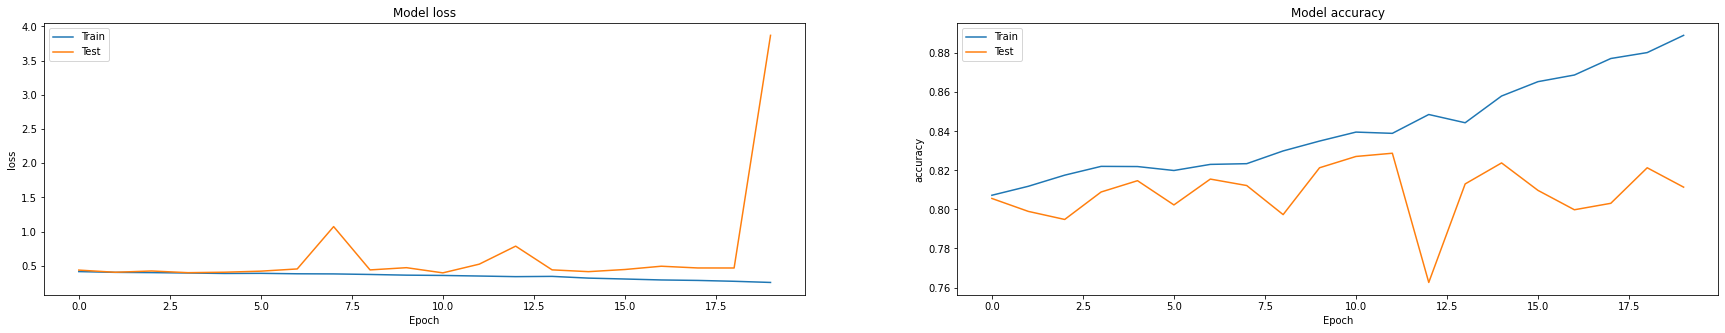

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

-- Oversampling the images which are predicted wrongly

In [ ]:
train.iloc[0]['images_paths']

'siim/dicom-images-train-jpg/1.jpg'

In [ ]:
imagesIndexes = []
for i in tqdm(range(len(train))):
    image = tf.keras.preprocessing.image.load_img(train.iloc[i]['images_paths'])
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)
    image = tf.expand_dims(image, axis = 0)
    prediction = model3.predict(image)

    if np.squeeze(prediction , -1).round() != train.iloc[i]['has_pneumothorax']:
        if prediction <= 0.3 or prediction >= 0.7:
            imagesIndexes.append(i)


100%|██████████| 12089/12089 [25:01<00:00,  8.05it/s]


In [ ]:
len(imagesIndexes)

910

In [ ]:
fileNames = train['images_paths']
labels = train['has_pneumothorax']

In [ ]:
fileNames.shape

(12089,)

In [ ]:
#Copy pasting so that these images appear two times
wrongPredictionImages = pd.Series(train.iloc[imagesIndexes]['images_paths'])
wrongPredictionLabels = pd.Series(train.iloc[imagesIndexes]['has_pneumothorax'])

In [ ]:
fileNames = fileNames.append(wrongPredictionImages, ignore_index=True)
labels = labels.append(wrongPredictionLabels, ignore_index= True)

In [ ]:
fileNames.shape

(12999,)

In [ ]:
fileNames.tail(2)

12997    siim/dicom-images-train-jpg/12053.jpg
12998    siim/dicom-images-train-jpg/12073.jpg
Name: images_paths, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fileNames, labels, test_size=0.10, stratify = labels, random_state=42)

In [ ]:
def read_image(datapoint):
    image = tf.keras.preprocessing.image.load_img(datapoint)
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction
    return image

def read_label(datapoint):
    datapoint = tf.reshape(datapoint, [1])
    return datapoint

def preprocess(image, label):
    def f(image, label):

        image = image.decode()
        image = read_image(image)

        a = np.random.uniform()
        if a>=0.80:
            b = np.random.uniform()
            if b<0.50:
                image = tf.image.flip_left_right(image)
            else:
                image = tf.image.flip_up_down(image)

        label = read_label(label)
        return image, label
    images, labels = tf.numpy_function(f, [image, label], [tf.float32, tf.int64])
    images.set_shape([img_size, img_size, 3])
    labels.set_shape([1])
    return images, labels

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=15000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
train_data = tf_dataset(X_train.values, y_train.values)

In [ ]:
def read_image(datapoint):
    image = tf.keras.preprocessing.image.load_img(datapoint)
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction
    return image

def read_label(datapoint):
    datapoint = tf.reshape(datapoint, [1])
    return datapoint

def preprocess(image, label):
    def f(image, label):

        image = image.decode()
        image = read_image(image)

        label = read_label(label)
        return image, label
    images, labels = tf.numpy_function(f, [image, label], [tf.float32, tf.int64])
    images.set_shape([img_size, img_size, 3])
    labels.set_shape([1])
    return images, labels

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=15000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
test_data = tf_dataset(X_test.values, y_test.values)

In [ ]:
model4 = Resnet34((256, 256, 3),[3, 4, 6, 3])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model4.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min'),
             history_Model1
]
optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
model4.compile(optimizer, loss = 'binary_crossentropy' , metrics=['accuracy'])

In [ ]:
#this is after changed pipeline
history4 = model4.fit(train_data, steps_per_epoch=len(train_data), epochs=1,\
                              validation_data=test_data,callbacks=callbacks, )

   2/1360 [..............................] - ETA: 52:28 - loss: 2.5245 - accuracy: 0.5000  

KeyboardInterrupt: ignored

In [ ]:
model4.load_weights("best_model3.h5")

In [ ]:
history4 = model4.fit(train_data, steps_per_epoch=len(train_data), epochs=4,\
                              validation_data=test_data,callbacks=callbacks, )

Epoch 1/4
1463/1463 [==============================] - 717s 490ms/step - loss: 0.3934 - accuracy: 0.8161 - val_loss: 0.3760 - val_accuracy: 0.8208
recall:  0.5644699140401146 - f1Score: 0.6283891547049442 - AUC: 0.7396482062314137
Epoch 2/4
1463/1463 [==============================] - 717s 490ms/step - loss: 0.3730 - accuracy: 0.8239 - val_loss: 0.3946 - val_accuracy: 0.8254
recall:  0.6819484240687679 - f1Score: 0.6770981507823612 - AUC: 0.7799857788062031
Epoch 3/4
1463/1463 [==============================] - 725s 496ms/step - loss: 0.3619 - accuracy: 0.8348 - val_loss: 0.3762 - val_accuracy: 0.8192
recall:  0.4899713467048711 - f1Score: 0.5927209705372616 - AUC: 0.7150172190937605
Epoch 4/4
1463/1463 [==============================] - 721s 493ms/step - loss: 0.3482 - accuracy: 0.8405 - val_loss: 0.4237 - val_accuracy: 0.8092
recall:  0.47564469914040114 - f1Score: 0.5724137931034482 - AUC: 0.7036477964682026


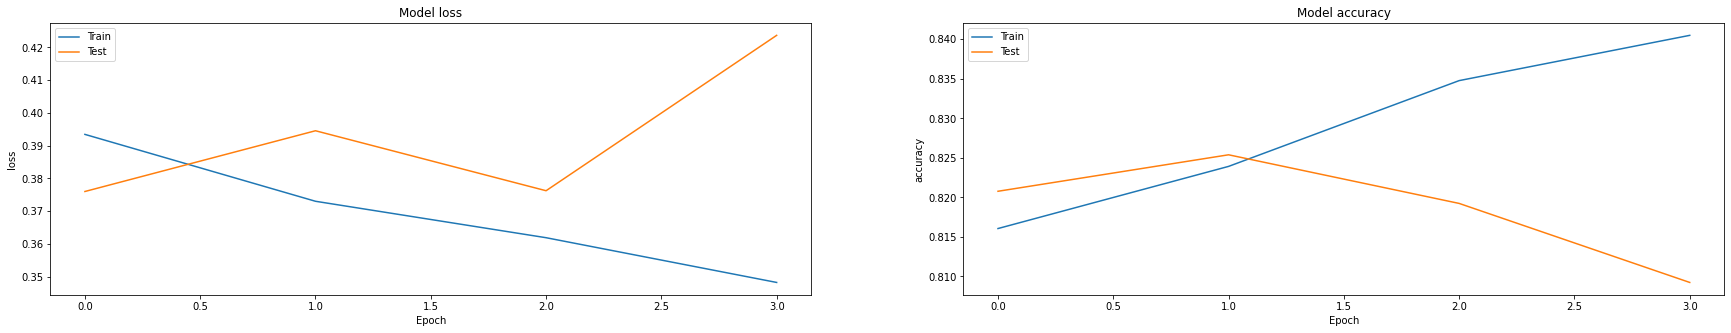

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
imagesIndexesOverSample = []
for i in tqdm(range(len(train))):
    image = tf.keras.preprocessing.image.load_img(train.iloc[i]['images_paths'])
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)
    image = tf.expand_dims(image, axis = 0)
    prediction = model4.predict(image)

    if np.squeeze(prediction , -1).round() != train.iloc[i]['has_pneumothorax']:
        if prediction <= 0.3 or prediction >= 0.7:
            imagesIndexesOverSample.append(i)


100%|██████████| 12089/12089 [25:05<00:00,  8.03it/s]


In [ ]:
len(imagesIndexesOverSample)

484

In [ ]:
#Saving the model 
model4.save("pneumothorax_classifier_oversampling")

INFO:tensorflow:Assets written to: pneumothorax_classifier_oversampling/assets


INFO:tensorflow:Assets written to: pneumothorax_classifier_oversampling/assets


In [ ]:
!zip -r /content/pneumothorax_classifier_oversampling.zip /content/pneumothorax_classifier_oversampling/

  adding: content/pneumothorax_classifier_oversampling/ (stored 0%)
  adding: content/pneumothorax_classifier_oversampling/variables/ (stored 0%)
  adding: content/pneumothorax_classifier_oversampling/variables/variables.index (deflated 80%)
  adding: content/pneumothorax_classifier_oversampling/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/pneumothorax_classifier_oversampling/assets/ (stored 0%)
  adding: content/pneumothorax_classifier_oversampling/saved_model.pb (deflated 91%)


Training on highly missclassified points reduced our highly missclassified points to half.

<h3>Comparison of two models</h3>

In [ ]:
from random import sample
listOfIndices = sample(imagesIndexes, 2)
listOfIndices

[7566, 9532]

In [ ]:
for index in listOfIndices:
    image = tf.keras.preprocessing.image.load_img(train.iloc[index]['images_paths'])
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)
    image = tf.expand_dims(image, axis = 0)
    #Old model
    prediction = model3.predict(image)
    print("Prediction using old model - (before oversampling) Actual Value :" , train.iloc[index]['has_pneumothorax'], " predicted value:" ,np.squeeze(prediction , -1).round())
    #New model
    prediction = model4.predict(image)
    print("Prediction using new model - (after oversampling)  Actual Value :" , train.iloc[index]['has_pneumothorax'], " predicted value:" ,np.squeeze(prediction , -1).round())
    print("\n")

Prediction using old model - (before oversampling) Actual Value : 1  predicted value: [0.]
Prediction using new model - (after oversampling)  Actual Value : 1  predicted value: [1.]


Prediction using old model - (before oversampling) Actual Value : 1  predicted value: [0.]
Prediction using new model - (after oversampling)  Actual Value : 1  predicted value: [1.]




 - Model is performing better after oversampling

Lets try changing the threshold

In [ ]:
model4.load_weights("best_model4.h5")

In [ ]:
def roundingOff(value, threshold):
    return 1 if value >=threshold else 0

def findingBestThreshold(thresholdList):
    truePositives = np.zeros(len(thresholdList))
    falseNegatives = np.zeros(len(thresholdList))
    for i in tqdm(range(len(train))):
        image = tf.keras.preprocessing.image.load_img(train.iloc[i]['images_paths'])
        image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
        image = tf.image.resize(image, [img_size, img_size])
        image = image / 255.0
        image = exposure.equalize_adapthist(image)
        image = tf.expand_dims(image, axis = 0)
        prediction = model4.predict(image)
        
        y_true = train.iloc[i]['has_pneumothorax']
        for thres in range(len(thresholdList)):
            y_pred = roundingOff(prediction, thresholdList[thres])

            if y_true == 1 and y_pred == 1:
                truePositives[thres] = truePositives[thres] + 1
            elif y_true == 1 and y_pred == 0:
                falseNegatives[thres] = falseNegatives[thres] + 1
    print()
    for thres in range(len(thresholdList)):
        print("Recall for threshold ", thresholdList[thres], "is: ", (truePositives[thres])/(truePositives[thres]+falseNegatives[thres]))

In [ ]:
thresholdList = [0.4, 0.45, 0.5, 0.6, 0.75]
findingBestThreshold(thresholdList)

100%|██████████| 12089/12089 [31:13<00:00,  6.45it/s]


Recall for threshold  0.4 is:  0.8130385912326714
Recall for threshold  0.45 is:  0.7853128512551517
Recall for threshold  0.5 is:  0.735481453727988
Recall for threshold  0.6 is:  0.6403147246159611
Recall for threshold  0.75 is:  0.4166354439865118


In [ ]:
thresholdList = [0.38, 0.39, 0.4, 0.41, 0.42]
findingBestThreshold(thresholdList)

100%|██████████| 12089/12089 [31:02<00:00,  6.49it/s]


Recall for threshold  0.38 is:  0.8291494941925814
Recall for threshold  0.39 is:  0.8227800674409891
Recall for threshold  0.4 is:  0.8130385912326714
Recall for threshold  0.41 is:  0.8077931809666542
Recall for threshold  0.42 is:  0.8029224428624954


- 0.38 is the best threshold.
- Further increasing the recall is resulting in decrease in precision so we are stopping at this point.